In [1]:
%cd /constellaration
%load_ext autoreload
%autoreload 2


[Errno 2] No such file or directory: '/constellaration'
/home/atulagrawal/constellaration/src/constellaration/generative_model


/home/atulagrawal/constellaration/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [6]:

import matplotlib.pyplot as plt
import numpy as np
from constellaration import forward_model, problems

from sklearn import decomposition, mixture, calibration

from constellaration.generative_model import bootstrap_dataset

from constellaration.generative_model import optimize_with_mcmc
import seaborn as sns


This file demonstrates the generative model approach for simple-to-build QI problem. 

### 1. Load data from HuggingFace and do PCA

In [ ]:

DATASET_MAX_TOROIDAL_MODE = 4
MAX_POLOIDAL_MODE = 4
MAX_TOROIDAL_MODE = 4
N_FIELD_PERIODS = 3
SEED = 24
dframe = bootstrap_dataset.load_and_concat_source_datasets_with_no_errors()
dframe = dframe[dframe["boundary.n_field_periods"] == N_FIELD_PERIODS]
dframe.head()
# dframe = bootstrap_dataset._unflatten_metrics_and_concatenate(dframe)
dframe = bootstrap_dataset._unserialize_surface(dframe)
dframe = bootstrap_dataset._augment_dataset(dframe)
print(f"Dataset size: {dframe.shape[0]}")

problem = problems.SimpleToBuildQIStellarator()
dframe.columns = [c.replace("metrics.", "") if c != "metrics.id" 
                  else c for c in dframe.columns]
dframe



In [ ]:

problem = problems.SimpleToBuildQIStellarator()
# Relax problem constraints
relaxation_factor = 0.33
#problem._aspect_ratio_upper_bound = 10.0 + 10.0 * relaxation_factor
problem._edge_rotational_transform_over_n_field_periods_lower_bound =0.25 - 0.25 * relaxation_factor # noqa: E501
problem._log10_qi_upper_bound = -4.0 + 4.0 * relaxation_factor
problem._edge_magnetic_mirror_ratio_upper_bound = 0.2 + 0.2 * relaxation_factor
problem._max_elongation_upper_bound = 5.0 + 5.0 * relaxation_factor

X = bootstrap_dataset._to_X(
    dframe=dframe,
    max_poloidal_mode=MAX_POLOIDAL_MODE,
    max_toroidal_mode=MAX_TOROIDAL_MODE,
)
Y_constraints = bootstrap_dataset._to_Y_constraints(
    dframe=dframe,
    problem=problem,
)
Y_objective = bootstrap_dataset._to_Y_objective(
    dframe=dframe,
    problem=problem,
)
n_feasible_candidates_in_the_data = np.sum(np.all(Y_constraints <= 0, axis=1))
print(f"Feasible candidates in the data: {n_feasible_candidates_in_the_data}")
 # 1. PCA reduction
pca = decomposition.PCA(n_components=0.9998, whiten=True)
Z = pca.fit_transform(X)
print(f"Reduced to {Z.shape[1]} dimensions.")


Feasible candidates in the data: 55
Reduced to 47 dimensions.


### 2. Train GMM and random forest classifiers

In [27]:

def get_classifier_regressor_GMM(
    X: np.ndarray,
    Y_cons: np.ndarray,
    pca_explained_variance: float,
    n_estimators: int,
    seed: int,
) -> np.ndarray:
    n_feasible_candidates_in_the_data = np.sum(np.all(Y_cons <= 0, axis=1))
    print(f"Feasible candidates in the data: {n_feasible_candidates_in_the_data}")

    # 1. PCA reduction
    pca = decomposition.PCA(n_components=pca_explained_variance, whiten=True)
    Z = pca.fit_transform(X)
    print(f"Reduced to {Z.shape[1]} dimensions.")

   # 2) Train a classifier per constraint
    constraint_classifiers: list[calibration.CalibratedClassifierCV] = []
    for j in range(Y_cons.shape[1]):
        y_bin = (Y_cons[:, j] <= 0).astype(int)
        print(y_bin)
        print(f"Constraint {j}: {np.sum(y_bin)} feasible candidates")
        classifier = bootstrap_dataset._fit_calibrated_classifier(
            X=Z,
            y=y_bin,
            random_state=seed,
            n_estimators=n_estimators,
        )
        constraint_classifiers.append(classifier)
        # Uncommet for debugging
        calibration.CalibrationDisplay.from_estimator(
            estimator=classifier,
            X=Z,
            y=y_bin,
            n_bins=10,
        )
        plt.show()

    probabilities = np.vstack(
        [clf.predict_proba(X=Z)[:, 1] for clf in constraint_classifiers]
    )
    print(f"Probabilities: {probabilities}")
    is_feasible = np.all(probabilities >= 0.8, axis=0)
    print(f"Number of samples used to fit GMM: {len(np.where(is_feasible)[0])}")

    # 3. Initialize GMM on PCA space
    #gmm_n_components = bootstrap_dataset._n_components_that_minimizes_bic(Z, seed=seed)
    gmm_n_components = 24
    gmm = mixture.GaussianMixture(n_components=gmm_n_components, random_state=seed)
    gmm.fit(Z[is_feasible])
    #gmm.fit(Z)
    print(f"Fitted GMM with {gmm_n_components} components.")

    return gmm, pca, constraint_classifiers


Feasible candidates in the data: 55
Reduced to 47 dimensions.
[1 1 1 ... 0 0 0]
Constraint 0: 56259 feasible candidates
Constraint OOB accuracy: 0.9812


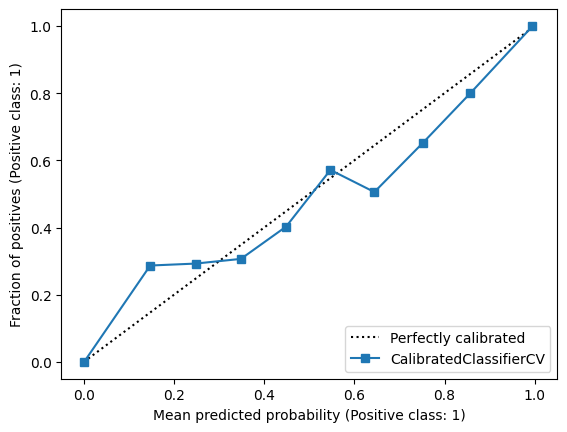

[1 0 1 ... 0 0 0]
Constraint 1: 54169 feasible candidates
Constraint OOB accuracy: 0.9854


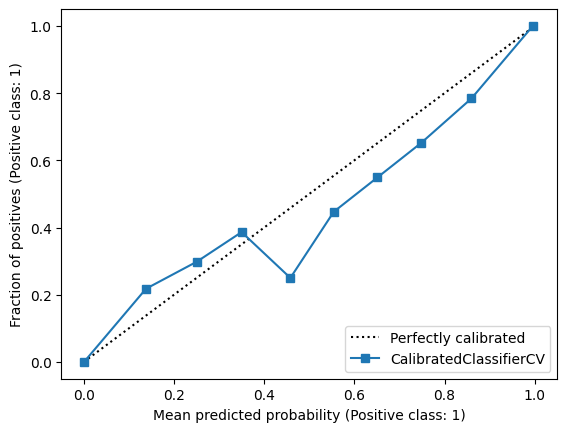

[0 0 1 ... 0 0 0]
Constraint 2: 2758 feasible candidates
Constraint OOB accuracy: 0.9875


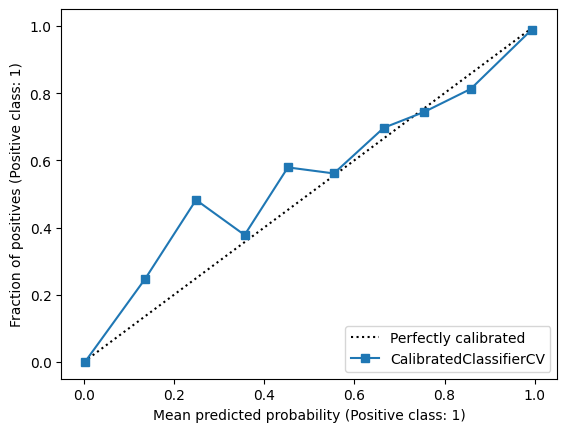

[0 0 0 ... 0 0 0]
Constraint 3: 7553 feasible candidates
Constraint OOB accuracy: 0.9726


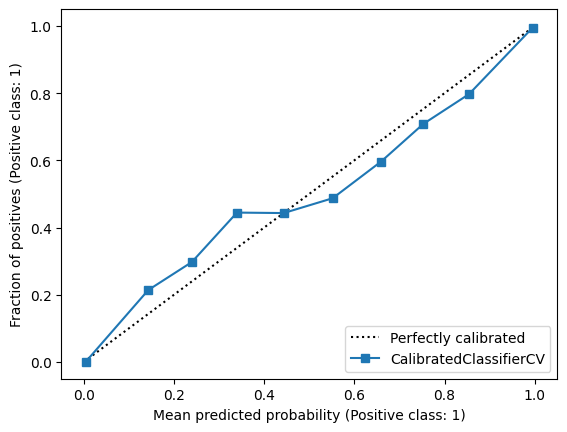

[0 0 1 ... 0 0 0]
Constraint 4: 63003 feasible candidates
Constraint OOB accuracy: 0.9827


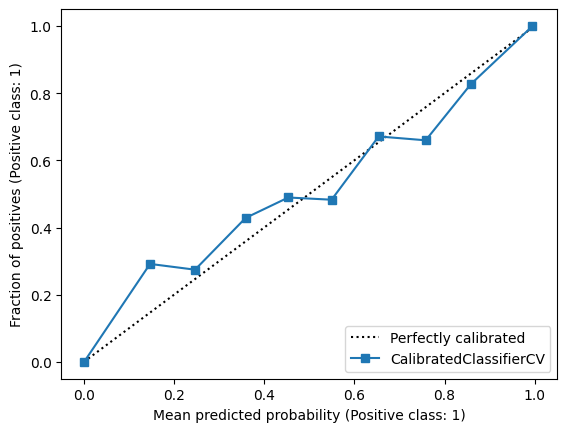

Probabilities: [[9.95133812e-01 9.37352307e-01 9.96300433e-01 ... 3.25484488e-04
  3.25484488e-04 3.25484488e-04]
 [9.96298553e-01 2.91963951e-01 9.96298553e-01 ... 4.21138906e-04
  4.50539468e-04 4.50539468e-04]
 [2.39309692e-03 1.49896751e-02 9.63684902e-01 ... 2.39309692e-03
  2.39309692e-03 2.39309692e-03]
 [3.69726257e-03 9.08206678e-02 3.46202400e-02 ... 3.19551857e-03
  3.19551857e-03 3.19551857e-03]
 [8.25714510e-03 5.54367062e-01 9.94265536e-01 ... 2.23841878e-04
  2.75751793e-04 2.39957424e-04]]
Number of samples used to fit GMM: 44
Fitted GMM with 24 components.


In [29]:
gmm, pca, constraint_classifiers = get_classifier_regressor_GMM(
        X=X,
        Y_cons=Y_constraints,
        pca_explained_variance=0.9998,
        n_estimators=200,#100,
        seed=SEED,
    )


### 3. MCMC
Take the GMM as a prior, with a "quasi likelihood" to maximize the probability of feasible domain, obtain a posterior with MCMC. 

In [ ]:
def log_prior(x):
    """Log prior for the GMM parameters."""
    #atleast 2d
    if x.ndim == 1:
        x = x.reshape(1, -1)
    return gmm.score_samples(x)
def quasi_log_likelihood(x):
    """Log likelihood for the GMM parameters."""
    if x.ndim == 1:
        x = x.reshape(1, -1)
    cons =[]
    for i,clf in enumerate(constraint_classifiers):
        p = clf.predict(X=x)
        cons.append(np.log(p + 1e-10))
    cons = np.array(cons)
    #cons = np.prod(cons, axis=0)
    cons = np.sum(cons, axis=0)
    # sum over the logp for three constraints
    return cons
def forward_(x): #noqa
    """Wrapper for the sphere function."""
    return None, None
history = {"x": [], "logp": []}  
def callback_print(state):
    """Callback function to save intermediate results."""
    # one can aslo save pickle files, or log to wandb.
    history["x"].append(state['current_sample'])
    history["logp"].append(state['logp'])
    if state["iteration"] % 100 == 0:
        print(f"Iteration: {state['iteration']}, logp: {state['logp']}")
probabilities = np.vstack(
        [clf.predict_proba(X=Z)[:, 1] for clf in constraint_classifiers]
    )
is_feasible = np.all(probabilities >= 0.995, axis=0)

Z[is_feasible].shape
# Run the optimization with mcmc
settings = optimize_with_mcmc.OptimizeWithMcmcSettings(
    num_samples=4000,
)


The dimension of the design space is 47
Running MCMC (Adaptive Random Walk Metrolopis Hastings)with 4000 samples


MCMC Sampling:   3%|▎         | 100/3999 [00:30<17:33,  3.70it/s]

Iteration: 100, logp: [-165957.65003529]


MCMC Sampling:   5%|▌         | 200/3999 [01:00<17:11,  3.68it/s]

Iteration: 200, logp: [-165957.65003529]


MCMC Sampling:   8%|▊         | 300/3999 [01:31<22:39,  2.72it/s]

Iteration: 300, logp: [-165957.65003529]


MCMC Sampling:  10%|█         | 400/3999 [02:00<17:27,  3.44it/s]

Iteration: 400, logp: [-165957.65003529]


MCMC Sampling:  13%|█▎        | 500/3999 [02:30<15:41,  3.71it/s]

Iteration: 500, logp: [-124312.42147445]


MCMC Sampling:  15%|█▌        | 600/3999 [03:00<14:52,  3.81it/s]

Iteration: 600, logp: [-124312.42147445]


MCMC Sampling:  18%|█▊        | 700/3999 [03:30<24:46,  2.22it/s]

Iteration: 700, logp: [-112727.21535566]


MCMC Sampling:  20%|██        | 800/3999 [04:00<15:42,  3.39it/s]

Iteration: 800, logp: [-95059.97736701]


MCMC Sampling:  23%|██▎       | 900/3999 [04:30<13:47,  3.75it/s]

Iteration: 900, logp: [-92600.98460611]


MCMC Sampling:  25%|██▌       | 1000/3999 [04:59<13:30,  3.70it/s]

Iteration: 1000, logp: [-84432.63501631]


MCMC Sampling:  28%|██▊       | 1100/3999 [05:29<12:42,  3.80it/s]

Iteration: 1100, logp: [-61995.66230134]


MCMC Sampling:  30%|███       | 1200/3999 [05:59<14:27,  3.23it/s]

Iteration: 1200, logp: [-46453.09646966]


MCMC Sampling:  33%|███▎      | 1300/3999 [06:29<12:24,  3.63it/s]

Iteration: 1300, logp: [-36381.59957291]


MCMC Sampling:  35%|███▌      | 1400/3999 [06:59<11:45,  3.69it/s]

Iteration: 1400, logp: [-32624.95718212]


MCMC Sampling:  38%|███▊      | 1500/3999 [07:29<16:32,  2.52it/s]

Iteration: 1500, logp: [-24365.50531766]


MCMC Sampling:  40%|████      | 1600/3999 [07:59<12:01,  3.32it/s]

Iteration: 1600, logp: [-21168.13485063]


MCMC Sampling:  43%|████▎     | 1700/3999 [08:29<10:29,  3.65it/s]

Iteration: 1700, logp: [-15856.99351413]


MCMC Sampling:  45%|████▌     | 1800/3999 [08:58<09:36,  3.81it/s]

Iteration: 1800, logp: [-13270.19133331]


MCMC Sampling:  48%|████▊     | 1900/3999 [09:29<15:47,  2.22it/s]

Iteration: 1900, logp: [-12155.16810433]


MCMC Sampling:  50%|█████     | 2000/3999 [09:58<09:25,  3.53it/s]

Iteration: 2000, logp: [-10504.28022129]


MCMC Sampling:  53%|█████▎    | 2100/3999 [10:28<08:21,  3.78it/s]

Iteration: 2100, logp: [-8464.76144439]


MCMC Sampling:  55%|█████▌    | 2200/3999 [10:58<07:51,  3.81it/s]

Iteration: 2200, logp: [-7399.68464856]


MCMC Sampling:  58%|█████▊    | 2300/3999 [11:28<10:01,  2.82it/s]

Iteration: 2300, logp: [-6377.69588647]


MCMC Sampling:  60%|██████    | 2400/3999 [11:57<07:32,  3.54it/s]

Iteration: 2400, logp: [-5340.44465087]


MCMC Sampling:  63%|██████▎   | 2500/3999 [12:27<06:39,  3.75it/s]

Iteration: 2500, logp: [-4436.51987889]


MCMC Sampling:  65%|██████▌   | 2600/3999 [12:57<10:30,  2.22it/s]

Iteration: 2600, logp: [-3970.93443802]


MCMC Sampling:  68%|██████▊   | 2700/3999 [13:27<06:30,  3.33it/s]

Iteration: 2700, logp: [-3531.37308989]


MCMC Sampling:  70%|███████   | 2800/3999 [13:57<05:29,  3.64it/s]

Iteration: 2800, logp: [-3122.03653022]


MCMC Sampling:  73%|███████▎  | 2900/3999 [14:26<05:03,  3.63it/s]

Iteration: 2900, logp: [-2916.90529905]


MCMC Sampling:  75%|███████▌  | 3000/3999 [14:57<06:34,  2.53it/s]

Iteration: 3000, logp: [-2681.19438407]


MCMC Sampling:  78%|███████▊  | 3100/3999 [15:27<04:27,  3.36it/s]

Iteration: 3100, logp: [-2450.61535822]


MCMC Sampling:  80%|████████  | 3200/3999 [15:56<03:41,  3.61it/s]

Iteration: 3200, logp: [-2220.93820123]


MCMC Sampling:  83%|████████▎ | 3300/3999 [16:26<03:01,  3.84it/s]

Iteration: 3300, logp: [-1900.90711548]


MCMC Sampling:  85%|████████▌ | 3400/3999 [16:56<04:26,  2.25it/s]

Iteration: 3400, logp: [-1777.36143011]


MCMC Sampling:  88%|████████▊ | 3500/3999 [17:26<02:23,  3.47it/s]

Iteration: 3500, logp: [-1504.17919896]


MCMC Sampling:  90%|█████████ | 3600/3999 [17:55<01:45,  3.77it/s]

Iteration: 3600, logp: [-1256.3250462]


MCMC Sampling:  93%|█████████▎| 3700/3999 [18:25<01:20,  3.72it/s]

Iteration: 3700, logp: [-1182.75856228]


MCMC Sampling:  95%|█████████▌| 3800/3999 [18:55<00:57,  3.47it/s]

Iteration: 3800, logp: [-1092.39964811]


MCMC Sampling:  98%|█████████▊| 3900/3999 [19:25<00:26,  3.72it/s]

Iteration: 3900, logp: [-1053.12002289]


MCMC Sampling: 100%|██████████| 3999/3999 [19:55<00:00,  3.35it/s]

Final Acceptance Ratio: 0.066, final Proposal Scale: 0.000


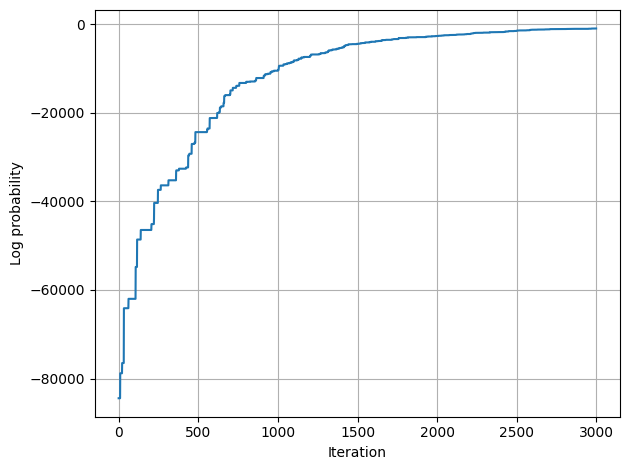

In [32]:

initial_guess = Z[is_feasible][0, :].reshape(-1)
initial_guess = initial_guess + initial_guess * 0.1 * np.random.randn(*initial_guess.shape) #noqa
mcmc_samples = optimize_with_mcmc.optimize_with_mcmc(
    function=forward_,
    x0=initial_guess,
    callback=callback_print,
    settings=settings,
    prior=log_prior,
    likelihood=quasi_log_likelihood,
)

plt.plot(history["logp"][1000:])
plt.xlabel("Iteration")
plt.ylabel("Log probability")
plt.grid()
plt.tight_layout()
plt.show()



In [ ]:

# randombly pick points from last 4000 points from mcmc_samples
feasible_points = mcmc_samples[-4000:][np.random.choice(mcmc_samples[-4000:].shape[0], size=50, replace=False)] #noqa
metrics_list = []
x_feasible =pca.inverse_transform(feasible_points)
for x_hat in x_feasible[-40:,:]:
#for x_hat in pca.inverse_transform(Z[is_feasible][8:10,:]):
    surface = bootstrap_dataset._x_to_surface(x_hat,
                                          max_poloidal_mode=MAX_POLOIDAL_MODE,
                                          max_toroidal_mode=MAX_TOROIDAL_MODE,
                                          n_field_periods=N_FIELD_PERIODS,)
    try:
        metrics = forward_model.forward_model(
            boundary=surface,
            settings=forward_model.ConstellarationSettings()
        )[0]
        metrics_list.append(metrics)
        print(f"Max elongation: {metrics.max_elongation}")
    except Exception as _:
        print("Error in forward model")
        metrics_list.append(np.nan)
        continue
for metrics in metrics_list:
    #metrics.edge_rotational_transform_over_n_field_periods*=-1
    # take abs value
    metrics.edge_rotational_transform_over_n_field_periods = np.abs(metrics.edge_rotational_transform_over_n_field_periods) #noqa: E501


/home/atulagrawal/constellaration/src/constellaration/mhd/geometry_utils.py:127: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  phi_perp = float(optimize.fsolve(_dot_tangent, x0=[phi_init])[0])


Max elongation: 5.15968104088079
Max elongation: 5.167712642657598
Max elongation: 5.150474746340147
Max elongation: 5.167596145038588
Max elongation: 5.084393930720007
Max elongation: 5.451827079348736
Max elongation: 5.298246672383342
Max elongation: 4.958387680652303
Max elongation: 5.161499312931833
Max elongation: 5.190287632867332
Max elongation: 4.719445773217853
Max elongation: 5.425438176091017
Max elongation: 6.046497736668632
Max elongation: 5.164423817983313
Max elongation: 5.696783608413075
Max elongation: 5.192671390660901
Max elongation: 5.210784844682928
Max elongation: 5.425438176091017
Max elongation: 5.965277676108808
Max elongation: 6.046497736668632
Max elongation: 5.210784844682928
Max elongation: 5.168317885804052
Max elongation: 4.719445773217853
Max elongation: 5.213886885767967
Max elongation: 5.214189956013953
Max elongation: 5.181805600335843
Max elongation: 6.046497736668632
Max elongation: 6.046497736668632
Max elongation: 5.19898169061181
Max elongation: 

### 5. Compare with VMEC++ and plot results
Might not match with the paper figure, as the seed would have changed. 

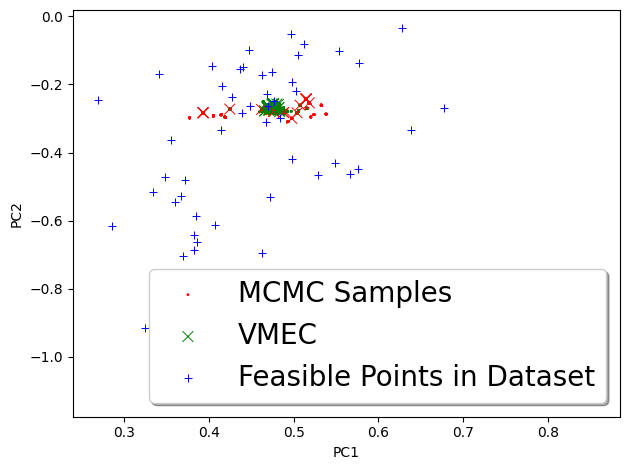

In [ ]:
# get feasible points in Z space in the dataset
idx_feasible= np.where(np.all(Y_constraints <= 0, axis=1))[0]
Z_feasible = Z[idx_feasible]

# Extract green points (where all constraints are satisfied)
c = np.all([
    (clf.predict(X=mcmc_samples) == 1) 
    & (clf.predict_proba(X=mcmc_samples)[:, 1] > 0.95)
    for clf in constraint_classifiers
], axis=0)

green_points = mcmc_samples[c]

# Create a KDE plot for the green points
fig, ax = plt.subplots()
sns.kdeplot(
    x=green_points[:, 0],
    y=green_points[:, 1],
    fill=True,
    cmap="Greens",
    ax=ax,
    alpha=0.6,
)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# Add the scatter plot on top of the KDE plot
ax.scatter(
    mcmc_samples[:, 0],
    mcmc_samples[:, 1],
    c=np.where(c, "green", "red"),
    s=1,
    label="MCMC Samples",
)

# Add green crosses for VMEC points
vmec_feasible = np.array([problem.is_feasible(metric) for metric in metrics_list])
# vmec_feasible = []
# for mm in metrics_list:
#     if isinstance(mm, numbers.Number) and np.isnan(mm):
#         vmec_feasible.append(False)
#     else:
#         vmec_feasible.append(problem.is_feasible(mm))
vmec_feasible = np.array(vmec_feasible)
ax.scatter(
    feasible_points[-40:, 0],
    feasible_points[-40:, 1],
    c=np.where(vmec_feasible, "green", "red"),
    marker="x",
    s=60,
    label="VMEC",
    linewidths=0.7,
)

# Add feasible points from the dataset
ax.scatter(
    Z_feasible[:, 0],
    Z_feasible[:, 1],
    c="blue",
    marker="+",
    s=30,
    label="Feasible Points in Dataset",
    linewidths=0.7,
)

#Set axis limits for the main plot
# ax.set_xlim(0.6, 1.2)
# ax.set_ylim(0.5, 2.0)

# # Add an inset plot
# inset_ax = inset_axes(ax, width="55%", height="55%", loc="upper right")
# sns.kdeplot(
#     x=green_points[:, 0],
#     y=green_points[:, 1],
#     fill=True,
#     cmap="Greens",
#     ax=inset_ax,
#     alpha=0.6,
# )
# inset_ax.scatter(
#     mcmc_samples[:, 0],
#     mcmc_samples[:, 1],
#     c=np.where(c, "green", "red"),
#     s=1.2,
# )
# inset_ax.scatter(
#     feasible_points[-40:, 0],
#     feasible_points[-40:, 1],
#     c=np.where(vmec_feasible, "green", "red"),
#     marker="x",
#     s=80,
#     linewidths=0.7,
# )
# inset_ax.scatter(
#     Z_feasible[:, 0],
#     Z_feasible[:, 1],
#     c="blue",
#     marker="+",
#     s=40,
#     linewidths=0.7,
# )

# # Set axis limits for the inset
# inset_ax.set_xlim(0.7, 0.8)
# inset_ax.set_ylim(1.1, 1.3)

# # Remove axis labels for the inset
# inset_ax.set_xticks([])
# inset_ax.set_yticks([])

# # Add zoom lines connecting the inset to the main plot
# mark_inset(ax, inset_ax, loc1=2, loc2=4, fc="none", ec="0.5", lw=1)

# Add labels, title, and legend
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.legend(
    loc="lower right",  # Move legend to bottom-right
    frameon=True,       # Add a bounding box
    fontsize=20,        # Adjust font size
    fancybox=True,      # Rounded corners for the box
    shadow=True         # Add shadow to the box
)
plt.tight_layout()

plt.show()
